## Step 1: Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Step 2: Data Loading and Exploration

In [2]:
# Load the dataset
df = pd.read_csv('uber_reviews.csv')

# View basic information
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   userName              12000 non-null  object 
 1   userImage             0 non-null      float64
 2   content               12000 non-null  object 
 3   score                 12000 non-null  int64  
 4   thumbsUpCount         12000 non-null  int64  
 5   reviewCreatedVersion  10260 non-null  object 
 6   at                    12000 non-null  object 
 7   replyContent          33 non-null     object 
 8   repliedAt             33 non-null     object 
 9   appVersion            10260 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 937.6+ KB
None
  userName  userImage          content  score  thumbsUpCount  \
0   User_0        NaN             Good      5              0   
1   User_1        NaN             Nice      5              0   
2   User_2        

## Step 3: Data Cleaning

In [3]:
# Drop irrelevant columns
df.drop(['userImage', 'replyContent', 'repliedAt'], axis=1, inplace=True)

# Handle missing values
df['content'] = df['content'].fillna('No Review')

# Convert date column to datetime
df['at'] = pd.to_datetime(df['at'])

# Print cleaned dataset info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   userName              12000 non-null  object        
 1   content               12000 non-null  object        
 2   score                 12000 non-null  int64         
 3   thumbsUpCount         12000 non-null  int64         
 4   reviewCreatedVersion  10260 non-null  object        
 5   at                    12000 non-null  datetime64[ns]
 6   appVersion            10260 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 656.4+ KB
None


## Step 4: Data Preprocessing for NLP

In [4]:
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources (run only once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Initialize NLTK resources
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocess text function
def preprocess_text(text):
    # Remove non-word characters (like punctuation)
    text = re.sub(r'\W', ' ', text)
    text = text.lower()  # Convert to lowercase
    # Tokenization using spaCy
    doc = nlp(text)
    # Remove stopwords and lemmatize
    text = [word.text for word in doc if word.text not in stop_words]
    text = [lemmatizer.lemmatize(word) for word in text]
    return ' '.join(text)

# Apply preprocessing to the 'content' column
df['cleaned_content'] = df['content'].apply(preprocess_text)

# Display the original and cleaned content
print(df[['content', 'cleaned_content']].head())


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tanzeem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tanzeem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tanzeem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


           content cleaned_content
0             Good            good
1             Nice            nice
2  Very convenient      convenient
3             Good            good
4         exllence        exllence


## Step 5: Sentiment Labeling

In [5]:
# Define sentiment labels based on scores
def label_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['score'].apply(label_sentiment)

# Check sentiment distribution
print(df['sentiment'].value_counts())


sentiment
Positive    8732
Negative    2935
Neutral      333
Name: count, dtype: int64


## Step 6: Data Visualization

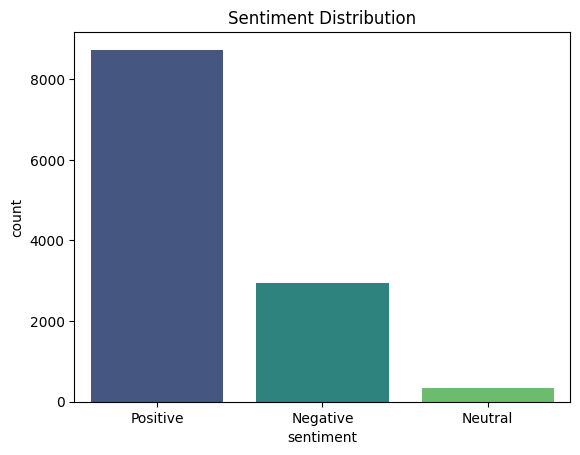

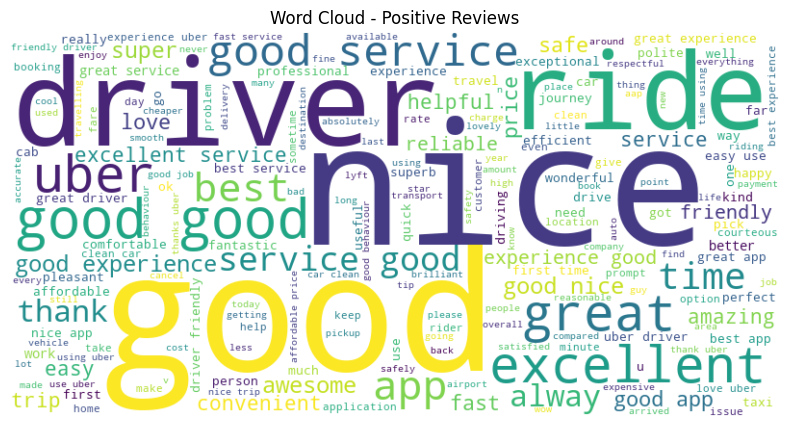

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment distribution
sns.countplot(x='sentiment', hue='sentiment', data=df, palette='viridis', legend=False)
plt.title('Sentiment Distribution')
plt.show()

# Word cloud for positive reviews
from wordcloud import WordCloud

positive_text = ' '.join(df[df['sentiment'] == 'Positive']['cleaned_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Reviews')
plt.show()


## Step 7: Model Building

              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82       554
     Neutral       1.00      0.00      0.00        80
    Positive       0.93      0.97      0.95      1766

    accuracy                           0.90      2400
   macro avg       0.91      0.60      0.59      2400
weighted avg       0.91      0.90      0.89      2400

Accuracy: 0.9033333333333333


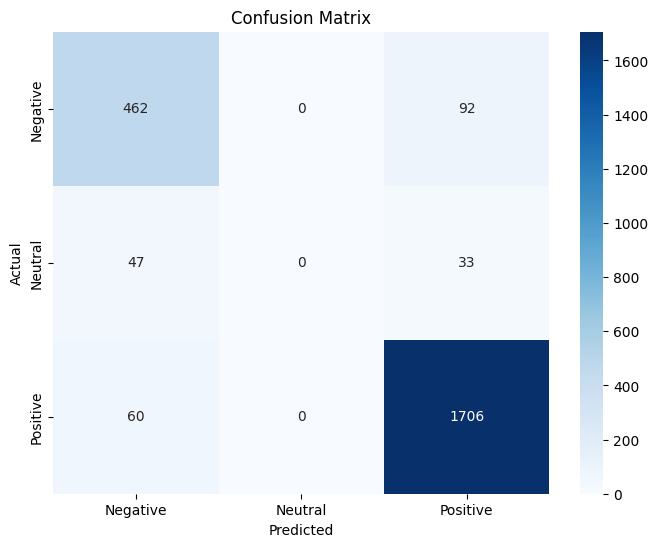

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Vectorize the text
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_content']).toarray()
y = df['sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))
print('Accuracy:', accuracy_score(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()